This is adopted from: [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)
[https://github.com/wendykan/DeepLearningMovies](https://github.com/wendykan/DeepLearningMovies)


# Building a corpus of abstracts from historical (pre-1900) texts using NLP

### Importing necessary libraries
All libraries installed using ```pip install [Name of package]```

In [177]:
# import block

# dependencies
import re # to identify non-letters
import requests
import time
from Bio import Entrez
import os

# natural language toolkit: off-the-shelf NLP software
import nltk
from nltk.corpus import stopwords

# off-the-shelf machine learning software
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LdaModel
from collections import Counter
from textblob import TextBlob # sentiment analysis
import torch # for making the model and evaluating it
# contains pre-trained machine learning model for NCBI/PubMed data
from transformers import BertTokenizer, BertModel 

# for manipulating data and doing math
import pandas as pd
import numpy as np

# for making plots
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# to read in data from Google Drive: PyDrive
from pydrive.auth import GoogleAuth # to authenticate connection to Drive
from pydrive.drive import GoogleDrive # to read in files from Drive

The API for the historical texts will connect to the shared Google folder.  
Assisted by ChatGPT output.

## Read in Historical Docs from Google Drive

### Connect to Google Drive
Steps adapted from 'read in a series of .txt files in nested folders in google drive' query in ChatGPT
- Create a Cloud Project for the Jupyter Notebook using Google Cloud
    - We may be able to all use the same Google Project, the details of that have not been worked out yet
- Enable APIs for your project
- Choose Google API
- Create and download a Google OAuth credentials file
    - Choose 'Desktop app' for app type
- Make yourself a test user on the Cloud Project
- Run the below code to connect to your Google Drive folder!

In [178]:
# open an authenticated connection to Drive
gauth = GoogleAuth()
gauth.LoadClientConfigFile('/Users/eleanor/Documents/Fall 2023/Plants & Python/Unit4_FinalProject/2023PlantsAndPython/client_secret.json')
gauth.LocalWebserverAuth()  # For authentication using a local web server
drive = GoogleDrive(gauth) # this is the drive we'll be working with

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=177591520756-n0hgl0detjnphfoagmcabaic4s9ipl2i.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


### Obtain information about the files
This could include title, content, size, date uploaded, etc. Here we will include only title, id, and file type.

In [179]:
# makes a list of all the files in a Google Drive folder
# folder_id can be obtained from the sharing link of a Drive folder
def list_files(folder_id):
    all_files = [] # a place to hold the list of file metadata
    
    # to get the list of files in the desired folder from Drive:
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList() 
    
    for file in file_list: # for all the files in this folder
        
        if file['mimeType'] == 'text/plain':  # Filter for text files
            # add title, id and type to the list of metadata
            all_files.append({'title': file['title'], 'id': file['id'], 'type': 'file'})
            
        elif file['mimeType'] == 'application/vnd.google-apps.folder':  # If it's a folder, list its contents
            
            # comment this line back in if you want to include folders in your list of superfolder contents
#             all_files.append({'title': file['title'], 'id': file['id'], 'type': 'folder'})
            
            # Recursive call to list_files for subfolders
            subfolder_files = list_files(file['id'])
            all_files.extend(subfolder_files)
            
    return all_files

In [180]:
# run the function above to retrieve a list of titles of files in the folder and their ids
file_metadata = list_files('1mJs-l06xx4QbPj01tBtC0rXNeKxN2h6u')


### Obtain the content of the files
Now that we've essentially un-nested the files, we can extract their contents as plain text.

In [181]:
# makes a list of all the contents of all the files
def get_file_content(file_id):
    file = drive.CreateFile({'id': file_id})
    file.GetContentFile('temp.txt')  # Download file content
    f = open('temp.txt', 'r', encoding='utf-8')

    # documented error: 
        # UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 1110: invalid continuation byte
    # so we implemented this try-except block
    # I think there's a logical error here, that it stops reading the file after there's a UnicodeDecodeError
    try:
        content = f.read()  # Read file content
    except UnicodeDecodeError:
        content = f.readline()

    return content

In [182]:
# a list to hold dictionaries of the file contents and their titles
file_contents = []

# get the file contents from all the files in the list of file metadata
for x in file_metadata:
    content = get_file_content(x['id'])
    file_contents.append({'title': x['title'], 'content': content})

# to organize and reformat the content, we put it into a dataframe
df = pd.DataFrame(file_contents)

In [183]:
# df.iloc[0,1]

In [184]:
# in order to do analyses, we want just the content, and in list format
content_list = df['content'].tolist()

If we print the first 2 texts, we can get a sense for how well our reading-in worked:

In [185]:
print(content_list[0:2])

['\n\nKING\'S \nCollege \nLONDON \nLibrary \n\\%\\\\ \n200912372 9 \nKING S COLLEGE LONDON \n•ay \n\n\n\nDigitized by the Internet Archive \nin 2015 \nhttps://archive.org/details/b21299559 \n\nTHE \nPRINCIPLES OF BOTANY, \nAND OF \nVEGETABLE PHYSIOLOGY \n\n\nPRINCIPLES OF \nAND OF \nVEGETABLE PHYSIOLOGY. \nTRANSLATED FROM THE GERMAN \nOf \nD. C. WILLDENOW\', \nPROFESSOR OF NATURAL HISTORY AND BOTANf \nAT BERLIN. \nW IfEJF HDITIONf GREATLY ENLARGED BY THE AVTnOi:. \nEDINBURGH : \nprinted at the Vniveriity Press : \nrOR WILLIAM BLACKWOOD, 64, SOUTH BRIDGE-STREET \nAND T. CADBLL AND W. DAVIES, STRAND, \nLONDON. \n1811. \n\n\nTO \nDANIEL RUTHERFORD, M. D., \nPROFESSOR OF BOTANY \nIN THE UNIVERSITY OF EDINBURGH, \nTHIS WORK IS \nMOST RESPECTFULLY INSCRIBED \nBY \nTHE EDITORS. \n\n\nADVERTISEMENT \nTO THE \nFIRST EDITION. \nThe following work havingv superseded in Germany \nall other Introductions to Botany, of the longest \nstanding and greatest reputation, it occurred to the \npresent Edit

Seems like we've got a lot of non-words...we'll see what the NLP analysis turns up

### Text Cleanup
The final step in data retrieval is to clean up the text, removing words like 'the' and 'and', that are important to the human reading of the text, but not to the kind of computational analyses we will do. The below object contains methods for turning a block of text into a 'bag of words' or 'bag of sentences.'

In [186]:
# We use a python class (kind of like a Java object) to break up the text into the parts of language
class KaggleWord2VecUtility(object):
    """KaggleWord2VecUtility is a utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review,"html.parser"  ).get_text()
        #
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        #
        # 5. Return a list of words
        return(words)

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append( KaggleWord2VecUtility.review_to_wordlist( raw_sentence, remove_stopwords ))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences


In [187]:
print ("Cleaning and parsing the content of the historical texts...\n")
num_texts = len(content_list)
clean_content = []
for i in range( 0, num_texts):
#     if( (i+1)%1000 == 0 ): 
#     print(" ".join(KaggleWord2VecUtility.review_to_wordlist(content_list[i], True)))
        clean_content.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(content_list[i], True)))

# We may want to save the text file at this point, so we don't have to keep re-generating the corpus?
# clean_content.to_csv('clean_texts.txt', sep = '\t')

Cleaning and parsing the content of the historical texts...



## Initial Analyses
In order to get a sense for what's in our data, we make some data visualizations.

### Metadata Analyses
We don't have any metadata as of now to analyze, but the below plots make a histogram of the year and country the texts were published, respectively.

In [188]:
# import seaborn as sns

# # Convert 'N/A' to NaN
# df['Year'] = df['Year'].replace('N/A', np.nan)

# # Drop rows with NaN in 'Year' column for histogram plotting
# df_filtered = df.dropna(subset=['Year'])

# # Convert the 'Year' column of the filtered dataframe to integer type
# df_filtered['Year'] = df_filtered['Year'].astype(int)

# # Plot the histogram with seaborn
# plt.figure(figsize=(10,6))
# sns.histplot(data=df_filtered, x='Year', bins=range(df_filtered['Year'].min(), df_filtered['Year'].max() + 2), kde=False, color='skyblue')

# plt.title('Distribution of published bean papers since the 1920s')
# plt.xlabel('Publication Year')
# plt.ylabel('Number of Publications')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()


In [189]:
# import pycountry
# # Function to check if a string is a valid country name
# def is_country(name):
#     try:
#         pycountry.countries.lookup(name)
#         return True
#     except:
#         return False

# # Explode and reset index
# exploded_df = df['Affiliations'].str.split('[;,.]').explode().reset_index()
# exploded_df.columns = ['original_index', 'Country']
# exploded_df['Country'] = exploded_df['Country'].str.strip()

# # Filter the valid countries
# exploded_df = exploded_df[exploded_df['Country'].apply(is_country)]

# # Count the occurrences and get the top 10
# top_countries = exploded_df['Country'].value_counts().head(10)

# # Plotting
# plt.figure(figsize=(12, 8))
# sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')
# plt.title('Top 10 Countries by Paper Count')
# plt.xlabel('Country')
# plt.ylabel('Number of Papers')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

### Textual Analyses
This cell makes a word cloud of the most common words in our texts.

In [190]:
# cleaned_abstracts = " ".join(clean_content)
# # Create a WordCloud object with custom settings
# wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=200).generate(cleaned_abstracts)

# # Display the word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")  # Turn off axis labels
# plt.show()

##  Natural Language Processing
Initial analyses are cool, but we want to be able to get into the weeds of things like sentiment analysis, PCoA, and knowledge graphs. In order to do this, we need to do some machine learning. Here, we make use of the pre-trained BERT models provided by the ```transformers``` package. 

In [191]:
# we need to initialize these two things no matter how we solve the size problem
tokenizer = BertTokenizer.from_pretrained("monologg/biobert_v1.1_pubmed")
model = BertModel.from_pretrained("monologg/biobert_v1.1_pubmed")

### Tokenization
To run a machine learning algorithm, we need to tokenize the texts. This means breaking up the text into smaller pieces that can be analyzed individually.

#### A small side note: debugging
Along the way, we ran into some errors that needed workarounds to be fixed. The first was that each of our tokens (pieces that the text had been broken up into) were too long. The code first put out this warning:  

```Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors```

And then produced this error after running the model:

```The expanded size of the tensor (94157) must match the existing size (512) at non-singleton dimension 1. Target sizes: [1, 94157].  Tensor sizes: [1, 512]```

The workaround we devised was, after tokenizing the text, we truncated the tokens so they were less than the 512 limit for the model. There are some other non-temporary fixes, that don't lose the data like trucation does. They include:
- Using a different model that's designed for longer data
- Implementing a sliding window that handles the tokens 512 positions at a time

Neither has yet been implemented, but there is code for the second included below.

In [192]:
# Temporary fix for the 'sequences are too long' error: truncate the sequences 
tokenized_texts = [tokenizer.tokenize(text) for text in clean_content]
max_token_length = 500
truncated_tokenized_texts = []

for text_tokens in tokenized_texts:
    truncated_tokens = text_tokens[:max_token_length]  # Keep only the first 500 tokens
    truncated_tokenized_texts.append(truncated_tokens)

In [193]:
# # the version where you create a sliding window to perform the model on the whole dataset

# # Define the maximum sequence length for the model
# max_sequence_length = model.config.max_position_embeddings

# # Initialize lists to store segment outputs and attention masks
# segment_outputs = []
# attention_masks = []

# # Define chunk size for processing
# chunk_size = 512  # Define your desired chunk size

# # tokenized_texts = [tokenizer.tokenize(abstract) for abstract in clean_content]
# # input_ids = [tokenizer.encode(abstract, add_special_tokens=True) for abstract in clean_content]

# # Process the input sequence in chunks
# for i in range(0, len(cleaned_abstracts), chunk_size):
#     # Get a chunk of the input sequence
#     chunk = cleaned_abstracts[i:i + chunk_size]

#     # Ensure the chunk fits within the maximum sequence length
#     if len(chunk) > max_sequence_length - 2:  # Accounting for [CLS] and [SEP]
#         chunk = chunk[:max_sequence_length - 2]

#     # Tokenize the chunk and convert it to tensors
#     inputs = tokenizer.encode_plus(chunk, add_special_tokens=True, return_tensors='pt')
#     input_ids = inputs['input_ids']
#     attention_mask = inputs['attention_mask']
    
#     # Perform inference on the chunk
#     with torch.no_grad():
#         outputs = model(input_ids, attention_mask=attention_mask)

#     # Store the outputs and attention masks
#     segment_outputs.append(outputs[0])  # Change outputs[0] to the desired output you need
#     attention_masks.append(attention_mask)

# # Merge outputs and attention masks if needed
# # Assuming segment_outputs and attention_masks are lists of tensors
# merged_outputs = torch.cat(segment_outputs, dim=1)
# merged_attention_masks = torch.cat(attention_masks, dim=1)

Now, with the truncated tokens, we can run the pre-trained model on each token by id.

In [194]:
# turn on eval mode for the model for the testing set
model.eval()

# a list to hold the embedded tokens
text_embeddings = []

# for each (truncated) token
for tokens in truncated_tokenized_texts:
    if tokens: # if the token isn't empty (see documented error #2 below)
        input_ids = tokenizer.encode(tokens, add_special_tokens=True) # encode the token as an id
        with torch.no_grad():
            outputs = model(torch.tensor([input_ids])) # create a tensor for each id
            text_embeddings.append(outputs[0][0, 0, :].numpy())  # Taking [CLS] token representation

#### Another small side note: more debugging
In the above code, we came across another error, that sometimes the truncated tokens were empty, producing the following error:

```ValueError: Input [] is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.```

This was a simple fix, with a check that the token wasn't empty, but in the implementation of other solutions to the 512 limit, figuring out why tokens are sometimes empty would be useful. 

### Clustering Analysis
One thing that NLP is good at is creating clusters, or sorting texts by topic. We performed this analysis next.

In [195]:
# Let's say you want to identify 5 clusters (topics). You can adjust this number as needed.
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(text_embeddings)


/Applications/anaconda3/envs/plantsandpython/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [196]:
# tokenizing the texts
tokenized_docs = [text.split() for text in clean_content]

# creating a dictionary of the tokens
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

# produce the clusters
NUM_TOPICS = 5  # Adjust this based on your needs
lda_model = LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)

In [197]:
# print out the topics generated and their respective weights/probabilities
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.011*"long" + 0.006*"leaves" + 0.004*"l" + 0.004*"one" + 0.004*"base"')
(1, '0.008*"leaves" + 0.008*"flowers" + 0.007*"species" + 0.004*"fruit" + 0.004*"africa"')
(2, '0.065*"de" + 0.031*"en" + 0.027*"la" + 0.019*"que" + 0.018*"las"')
(3, '0.004*"lin" + 0.003*"summer" + 0.003*"platte" + 0.003*"denver" + 0.003*"corolla"')
(4, '0.011*"v" + 0.008*"f" + 0.008*"fr" + 0.006*"w" + 0.006*"b"')


As demonstrated also by the word cloud, the most common topics include articles in Spanish (el, la, etc.) and singular letters (r, f, v). This, to me, indicates that it is, in fact, important to look more closely at the cleaning and filter out the weird characters. 

### Data Visualization
As in all things data-oriented, a bit of data visualization can show us how our output is distributed, what statistics we might perform on it, and other useful processing. We demonstrate a histogram and various printouts below. In the previous version of this notebook, sentiment analysis and a TSNE were performed, but there were more difficulties with input size, so we have elected to leave those out for now. 

In [198]:
for i, review in enumerate(clean_content[:10]):  # Displaying topics for the first 10 reviews
    bow = dictionary.doc2bow(review.split())
    topic_scores = lda_model[bow]
    dominant_topic = sorted(topic_scores, key=lambda x: x[1], reverse=True)[0]
    print(f"Text {i + 1} has dominant topic {dominant_topic[0]} with probability {dominant_topic[1]:.4f}")

Text 1 has dominant topic 0 with probability 0.9631
Text 2 has dominant topic 1 with probability 0.9994
Text 3 has dominant topic 2 with probability 1.0000
Text 4 has dominant topic 0 with probability 0.9999
Text 5 has dominant topic 1 with probability 0.9851
Text 6 has dominant topic 1 with probability 1.0000
Text 7 has dominant topic 0 with probability 0.2000
Text 8 has dominant topic 0 with probability 0.9854
Text 9 has dominant topic 0 with probability 0.9789
Text 10 has dominant topic 0 with probability 0.6446


In [199]:
dominant_topics = []
for review in corpus:
    topic_scores = lda_model[review]
    dominant_topic = sorted(topic_scores, key=lambda x: x[1], reverse=True)[0][0]
    dominant_topics.append(dominant_topic)

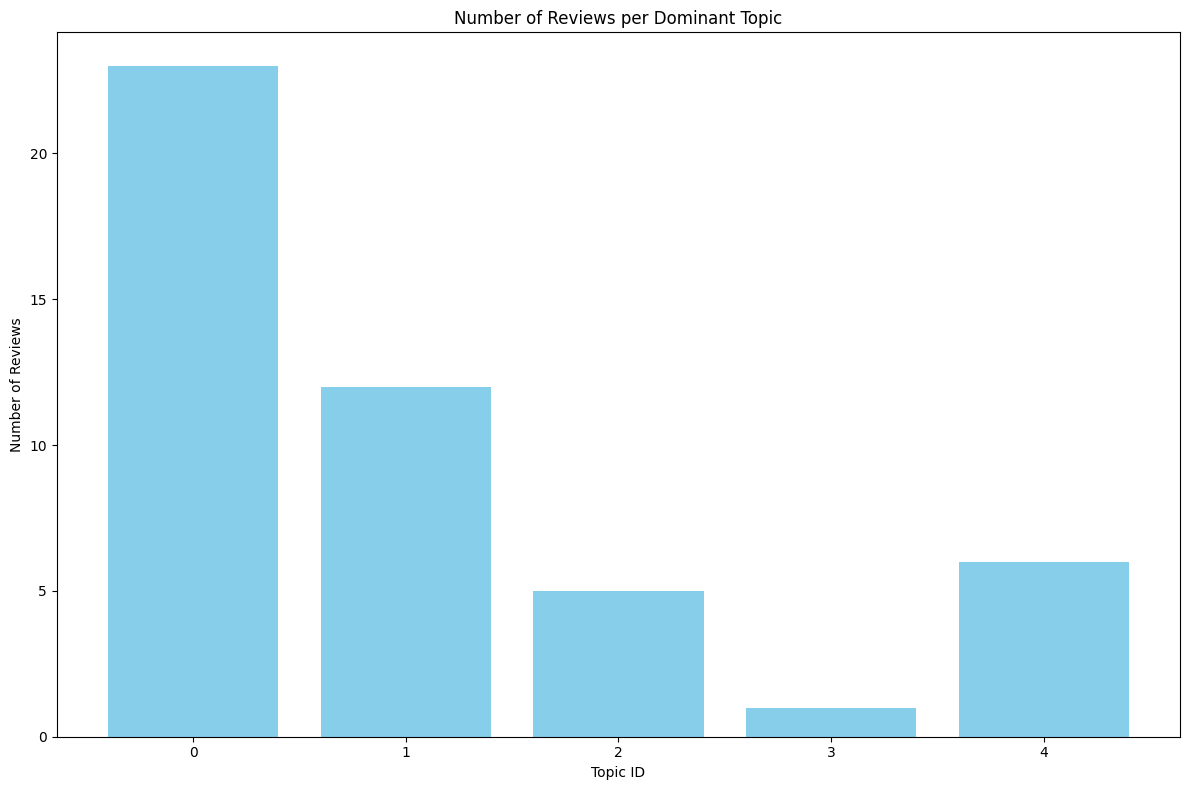

In [200]:
topic_counts = Counter(dominant_topics)
topics = list(topic_counts.keys())
counts = list(topic_counts.values())

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(topics, counts, color='skyblue', align='center')
plt.xlabel('Topic ID')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Dominant Topic')
plt.xticks(topics)  # Ensures that each topic ID gets its own tick on the x-axis
plt.tight_layout()
plt.show()

In [201]:
from sklearn.cluster import KMeans

# Define the number of clusters you want
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

This provides an idea of which cluster each review has been assigned to, helping you understand the grouping done by the KMeans algorithm.

Keep in mind that clustering, especially with text data, might not always give clear or meaningful clusters on the first try. You might need to experiment with different parameters, feature extraction methods, and even clustering algorithms to get the desired results.






## In Summary
Overall, I think this gives us a good first look at the historical data! Some things to consider in improving this analysis:
- How do we perform the analyses without truncating the tokens? How could they be tokenized differently? Can we use a different model?
- How can we clean the data better? What parameters can we alter that will remove more of what we consider to be 'stopwords'?